In [1]:
#import relevant packages for analysis

from __future__ import print_function

import os
import sys

import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_context('talk')
import random
from scipy.stats import randint
import pickle


PROJ_ROOT = os.path.join(os.pardir)

In [2]:
%load_ext watermark
%watermark -a "Bryan Dickinson" -d -t -v -p numpy,pandas,scikitlearn

Bryan Dickinson 2019-08-07 13:42:42 

CPython 3.7.3
IPython 7.7.0

numpy 1.16.4
pandas 0.25.0
scikitlearn not installed


## What is a Frisk?

A frisk is a type of search that requires a lawful stop. It involves contact or patting of the person's outer clothing to detect if a concealed weapon is being carried. The frisk doesn't necessarily always follow a stop. The law of frisk is based on the "experienced police officer" standard whereby an officer's experience makes him more equipped to read into criminal behavior than the average layperson.

The purpose of a frisk is to dispel suspicions of danger to the officer and other persons. The frisk should only be used to detect concealed weapons or contraband. If other evidence, such as a suspected drug container, can be felt under the suspect's clothing, it can be seized by the officer. 

**A Justified Frisk**

A frisk is justified under the following circumstances:

- Concern for the safety of the officer or of others.
- Suspicion the suspect is armed and dangerous.
- Suspicion the suspect is about to commit a crime where a weapon is commonly used.
- Officer is alone and backup has not arrived.
- Number of suspects and their physical size.
- Behavior, emotional state, and/or look of suspects.
- Suspect gave evasive answers during the initial stop.
- Time of day and/or geographical surroundings (not sufficient by themselves to justify frisk).

A stop requires Reasonable Suspicsion, a set of factual circumstances that would lead a reasonable police officer to believe criminal activity is occurring. A Frisk is based on the 'experienced policed officer'. A few of the above behaviors can be subjective. From the Exploratory Data Analysis, we found that Subjects stopped of White race were 'frisked ' at a much lower rate than all the other races. 

Can the occurence of a Frisk be predicted based on the demographics of the officer and subject? 

In [3]:
#Create the path to the data and read into a pandas dataframe

terry_data = os.path.join(PROJ_ROOT, 
                         'data', 'processed',
                         'Terry_Stops_Clean.csv')

data = pd.read_csv(terry_data, parse_dates = ['date'], 
                   index_col = 'date', dtype = {'officer_race':'category','officer_gender':'category',
                                                'subject_age':'category',
                                                'subject_race':'category','subject_gender': 'category',
                                                'stop_resolution': 'category','weapon_type':'category',
                                                'call_type':'category','arrest':'int32', 'frisk':'float',
                                                'precinct':'category', 'sector':'category', 'beat': 'category'})

data.sort_index(inplace = True)

In [4]:
def split_mean(x):
    #Function to split the Age bins and return the mean of the two numbers
        if '-' in x:
            split_list = x.split('-')
            mean = (float(split_list[0]) + float(split_list[1]))/2
        else:
            mean = 56
        return mean


In [5]:
columns_to_drop = ['officer_squad','stop_resolution','officer_race', 'officer_age', 'officer_gender',
                   'weapon_type', 'arrest','initial_call_type','precinct', 'sector','subject_id']


In [6]:
df = data.drop(columns_to_drop, axis = 1)

df.head()

,officer_id,subject_age,subject_race,subject_gender,call_type,frisk,beat
date,,,,,,,
2015-03-15,115,1 - 17,Black,Female,NaN,1.0,NaN
2015-03-16,1757,18 - 25,Black,Male,NaN,0.0,NaN
2015-03-16,1735,36 - 45,Multi-Racial,Male,NaN,0.0,NaN
2015-03-16,1735,18 - 25,White,Male,NaN,0.0,NaN
2015-03-17,1735,26 - 35,White,Male,NaN,0.0,NaN


In [7]:
#replace age bins with the mean for the subject_age column
df['subject_age'] = df.subject_age.apply((split_mean))


# removing the 'Unkown' & 'Other' entries for the target variable

df = df[(df.subject_race != 'Unknown') & (df.subject_race != 'Other')]

#subset only the call type of 'onview'
df = df[df.call_type == 'ONVIEW']

#drop NaN values in the dataframe
df.dropna(inplace = True)

#remove all unused categories
for col in df.select_dtypes(include = ['category']).columns:
    df[col] = df[col].cat.remove_unused_categories()

#create a dictionary of the category codes and corresponding race strings
race_cat_codes = dict(enumerate(df['subject_race'].cat.categories))  
    
#create the pattern to match the beat entries
pattern = re.compile( '^[A-Z][1-9]$')

#drop any NaNs in the beat column
df = df.dropna(subset = ['beat'])

#use the pattern created to subset the data and get rid of the erroneous entries
df = df[(df.beat.str.contains(pattern))]

#remove all unused categories
for col in df.select_dtypes(include = ['category']).columns:
    df[col] = df[col].cat.remove_unused_categories()

    

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4852 entries, 2015-03-18 to 2019-05-06
Data columns (total 7 columns):
officer_id        4852 non-null int64
subject_age       4852 non-null category
subject_race      4852 non-null category
subject_gender    4852 non-null category
call_type         4852 non-null category
frisk             4852 non-null float64
beat              4852 non-null category
dtypes: category(5), float64(1), int64(1)
memory usage: 140.9 KB


In [8]:

#find the value counts of each officer, and create a mask for 10 or more occurences
#create a list of officers that have 10 or more frisks
ls = list(df.officer_id.value_counts()[df.officer_id.value_counts() >= 10].index)

#use the above list to filter the data for only officers with 10 or more frisks
df = df[df.officer_id.isin(ls)]

df.head()

,officer_id,subject_age,subject_race,subject_gender,call_type,frisk,beat
date,,,,,,,
2015-03-18,1735,30.5,White,Male,ONVIEW,0.0,E2
2015-03-18,1735,40.5,White,Male,ONVIEW,0.0,E2
2015-03-18,1735,21.5,White,Male,ONVIEW,0.0,E2
2015-03-18,1827,50.5,American Indian / Alaskan Native,Male,ONVIEW,0.0,C2
2015-03-18,1735,40.5,Black,Male,ONVIEW,0.0,E2


To help the classifier identify trends in frisks - we have limited the officers to only officers that have 10 or more frisks in the data set

In [9]:
# get an idea of how imbalanced the dataset is
df.frisk.value_counts()

0.0    2371
1.0     546
Name: frisk, dtype: int64

# Build the Classifier
Can the occurence of a frisk be predicted based on the officer, beat, and demographics of the subject?

In [10]:
#import relevent classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

#import preprocessing, metrics & pipelines
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, precision_score


In [11]:
#The metric that will be used is log loss. log loss is a log function is a measure of error. 
#The error should be as small as possible.

def compute_log_loss(predicted, actual, eps = 1e-14):
    #computes the logarithmic loss between predicted and actual when these are 1d arrays
    predicted = np.clip(predicted, eps, 1-eps)
    loss = -1 * np.mean(actual * np.log(predicted)
                       + (1 - actual)
                       * np.log(1-predicted))
    return loss

def consolidate_array(arr, cols = [0,1,2,3,4,5]):
    #function to transform the dummies array to a single column
    
    df = pd.DataFrame(arr, columns = cols)
    return(df.idxmax(axis = 1).values)

In [12]:

#set up the target variable
y = df['frisk'].values


#set the x variables by converting the categorical text features to dummy variables
X = pd.get_dummies(df.reset_index(drop = True).drop(['frisk', 'call_type'], axis = 1),
                          columns = ['subject_gender', 'subject_race', 'beat'] )


In [13]:
X.head()

,officer_id,subject_age,subject_gender_Female,subject_gender_Male,subject_gender_Unable to Determine,subject_race_American Indian / Alaskan Native,subject_race_Asian,subject_race_Black,subject_race_Hispanic,subject_race_Multi-Racial,...,beat_R3,beat_S1,beat_S2,beat_S3,beat_U1,beat_U2,beat_U3,beat_W1,beat_W2,beat_W3
0,1735,30.5,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1735,40.5,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1735,21.5,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1827,50.5,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1735,40.5,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
print(y.shape)
print(X.shape)

(2917,)
(2917, 62)


In [15]:
#split the data to test & training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, 
                                                    random_state = 5, stratify = y)


#build the pipline with upsampling & scaling the data
pipeline = imbPipeline([('sm', SMOTE(random_state = 5,
                                     sampling_strategy = 'not majority')),
               ('scale', StandardScaler()),
               ('clf', LogisticRegression())
              ])

#paramters for tuning
parameters = [
    {'clf' : [ LogisticRegression(random_state = 5)],
    'clf__C' : np.logspace(-5, 8, 10),
    'clf__solver' : ['lbfgs']},
    {'clf' : [ RandomForestClassifier(random_state = 5)],
    'clf__max_depth':[4, 3, None],
    'clf__n_estimators' : [50,100, 120, 140],
    'clf__max_features' : ['auto', 2, 4]},
    {'clf' : [ SVC()],
     'clf__kernel' : ['rbf', 'linear'],
     'clf__gamma' : ['auto','scale', 1, 4, 8, 10],
     'clf__C' : np.arange(1,18,5),
    'clf__probability' : [False]},
    {'clf' : [GaussianNB()]}
]

#create the grid search object
cv = GridSearchCV(pipeline,
                  param_grid=parameters,
                  refit = True,
                  cv = 5, 
                  verbose = True,
                  n_jobs = -1)

#fit the data
cv.fit(X_train, y_train)



Fitting 5 folds for each of 95 candidates, totalling 475 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 31.1min
[Parallel(n_jobs=-1)]: Done 475 out of 475 | elapsed: 44.5min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('sm',
                                        SMOTE(k_neighbors=5, kind='deprecated',
                                              m_neighbors='deprecated',
                                              n_jobs=1, out_step='deprecated',
                                              random_state=5, ratio=None,
                                              sampling_strategy='not majority',
                                              svm_estimator='deprecated')),
                                       ('scale',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('clf',
                                        Log...
                                      kernel

In [16]:
#save the model to disk
fname = 'frisk_model.sav'
pickle.dump(cv, open(fname, 'wb'))

In [17]:
#identify the best classifier and parameters
cv.best_params_

{'clf': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                        max_depth=None, max_features='auto', max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=100,
                        n_jobs=None, oob_score=False, random_state=5, verbose=0,
                        warm_start=False),
 'clf__max_depth': None,
 'clf__max_features': 'auto',
 'clf__n_estimators': 100}

In [18]:
#predict on the test set
y_pred = cv.predict(X_test)

#capture the prediction probabilities
y_predict_proba = cv.predict_proba(X_test)[:,1]

In [19]:

#scoring metrics
acc_score = cv.score(X_test, y_test)
roc_auc = roc_auc_score(y_test, y_predict_proba)

print('The accuracy score is: {}'.format(acc_score))
print('The AUC score is: {}'.format(roc_auc))


#print the confusion matrix and classification report from the best model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

The accuracy score is: 0.7962328767123288
The AUC score is: 0.6890101400289714
[[431  44]
 [ 75  34]]
              precision    recall  f1-score   support

         0.0       0.85      0.91      0.88       475
         1.0       0.44      0.31      0.36       109

    accuracy                           0.80       584
   macro avg       0.64      0.61      0.62       584
weighted avg       0.77      0.80      0.78       584



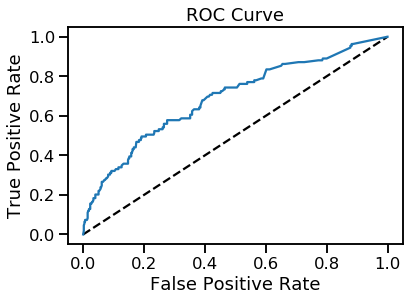

In [20]:
# Generate ROC curve values fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_predict_proba)

# Plot ROC curve
_=plt.plot([0, 1], [0, 1], 'k--')
_=plt.plot(fpr, tpr)
_=plt.xlabel('False Positive Rate')
_=plt.ylabel('True Positive Rate')
_=plt.title('ROC Curve')
plt.show()

In [21]:

#obtain the feature importances from within the GridSearchCV, pipeline, & OneVsRest objects
fi = [x.feature_importances_ for x in cv.best_estimator_.steps[2][1].estimators_]
fi = np.mean(fi, axis = 0)

#place the feature importances in a dataframe
feature_importances = pd.DataFrame(fi,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances.head(5)

,importance
officer_id,0.201131
subject_age,0.099657
subject_race_White,0.099539
subject_race_Black,0.077003
subject_gender_Male,0.055550


In [22]:
#create a dataframe to view target predictions & actuals side by side
preds = pd.concat([pd.DataFrame(y_pred), pd.DataFrame(y_test)],ignore_index = True, axis =1)

#add columns for clarity
preds.columns = ['prediction','actual']

preds.head(10)

,prediction,actual
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
5,1.0,0.0
6,0.0,0.0
7,0.0,1.0
8,0.0,0.0
9,0.0,0.0


# Findings

The model has a weighted average AUC score of .689, precision .77, recall .80 and accuracy score of 80%. Though when looking at only the positive class, those values drop to:
- precision **.44**
- recall **.31**

These values suggesst that the classifier is not accuratley predicing a Frisk given the data. The majority of values predicted are of the negative class. 

Looking at the top important features, we see that the top feature is officer_id, followed by the subject age, the subject being of a White Race, the subject being of a black race and the male gender. 

Underscoring that officers use their set of circumstances to determin a frisk, though more information is needed aside from subject demographics. 


Eventhough there is a significant difference among races in terry stops and frisk, more analysis is needed to discover if there is any bias present. For instance

   - A cluster analysis can be performed to investigate if there are groups of officers that stop certain subjects
   - A time series approach, identifying stops or frisks of a class of subjects during certain times of day
   - Capturing and analyzing the circumstances used for a stop/frisk
 
There are other interesting questions that this dataset may shed light on aside from racial features, for example:
  - Can we identify officers that have a high prevelance of initiating an onview stop that results in finding a weapon? To help identify and discover what behaviors were observed?
  - Can the probability of a weapon be predicted to help identify areas or give officers a warning?
